In [1]:
%pip install numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

# 20newsgroups por ser un dataset clásico de NLP ya viene incluido y formateado
# en sklearn
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import random as rnd
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML


### Consigna del desafío 1

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Construir un modelo de clasificación por prototipos (tipo zero-shot). Clasificar los documentos de un conjunto de test comparando cada uno con todos los de entrenamiento y asignar la clase al label del documento del conjunto de entrenamiento con mayor similaridad.

**3**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**4**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares. **La elección de palabras no debe ser al azar para evitar la aparición de términos poco interpretables, elegirlas "manualmente"**.


### Punto 1

#### Dataset 20 newsgroups, carga de datos

In [3]:
# cargamos los datos (ya separados de forma predeterminada en train y test)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

#### Vectorización

In [4]:
# Vectorizo el dataset de train
tfidfvect = TfidfVectorizer()
X_train = tfidfvect.fit_transform(newsgroups_train.data)
y_train = newsgroups_train.target
# Vectorizo el dataset de test 
X_test = tfidfvect.transform(newsgroups_test.data)
y_test = newsgroups_test.target

#### Similitud

In [5]:
rnd.seed(92)
# Tomo 5 muestras al azar, sobre los documentos vectorizados para el set de test.
doc_idxs = rnd.sample(range(0, X_test.shape[0]), 5)

for idx in doc_idxs:
    # Por cada muestra, busco los documentos similares
    cossim = cosine_similarity(X_test[idx], X_test)[0]
    # Ordeno los resultados de mayor a menor y me quedo con los 5 indices mas similares, ingorando el primero, que es el mismo documento
    mostsim = np.argsort(cossim)[::-1][1:6]
    list_sims = []
    for sim in mostsim:
        list_sims.append({"index": sim, "similitud": cossim[sim], "target": newsgroups_test.target_names[y_test[sim]], "texto": newsgroups_test.data[sim]})
    df_sims = pd.DataFrame(list_sims)
    print(f"Similitudes para documento: {idx}\nlabel: {newsgroups_test.target_names[y_test[idx]]}\ntexto:\n{newsgroups_test.data[idx]}")
    html_table = df_sims.to_html().replace("\\n", "<br>").replace("\\t", "&#09;")
    display(HTML(html_table))
    print("*****************************************")

# print (docs)

Similitudes para documento: 3449
label: talk.politics.guns
texto:

Funny, the medical examiner today stated that there was no
evidence ONE WAY or ANOTHER that there were bullet wounds --
not a single autopsy has been performed, so all reports are
deemed speculative.  INCLUDING reports that there were NO
bullet wounds.


Before long, I think all the kneejerk conspiracy theorists
are going to start getting pretty pissed off at how easily
they mislead themselves.  Also, pretty disappointed at
being ignored by the coutnry.



,index,similitud,target,texto
0,1121,0.461568,talk.politics.guns,"Apparently needing to clarify his comments from Thursday, Dr. NizamPlawaby (spelling?), the Medical Examiner for Tarrant County, Texas,who has authority in the Waco deaths, stated that since no autopsieshad been performed, there is no evidence for bullet wounds, or evidence against bullet wounds.Janet Reno also stated that she had never been told of bullet woundsby anyone in the Justice Department."
1,832,0.317879,talk.religion.misc,". It should be remembered that all of the first reports came from the FBI, and that independent observers, i.e. the press, were not allowed to get close and see things for themselves. Official communiques tend to be self-serving for the agencies that issue them. People in general tend to believe first reports, as these get the most and the biggest headlines. Corrections are often overlooked. An example is the FBI report that several of the bodies found in the rubble had bullet wounds. The local coroner, who is independent of the FBI, has so far found no bullet wounds!"
2,4763,0.245326,talk.politics.guns,"In the interest of accuracy (seems a liitle late to startthat, I know) the medical examiner has *not* contradictedthe FBI.The FBI said they found some folks who had been shot inthe head, and the medical examiner said ""we have not seenevidence of this"".At the time the medical examiner said that, they were dealingwith charred bodies in the compound - this sounds liketypical medical examiner not releasing details untila thorough investigation. The medical examiner sayinghe hasn't seen something is *not* the same thing as sayingthat it isn't there."
3,613,0.239701,talk.politics.misc,"Yesterday, the FBI was saying that at least three of the bodies hadgunshot wounds, indicating that they were shot trying to escape thefire. Today's paper quotes the medical examiner as saying that thereis no evidence of gunshot wounds in any of the recovered bodies.At the beginning of this siege, it was reported that while Koreshhad a class III (machine gun) license, today's paper quotes thegovernment as saying, no, they didn't have a license.Today's paper reports that a number of the bodies were found withshoulder weapons next to them, as if they had been using them whiledying -- which doesn't sound like the sort of action I would expectfrom a suicide.Our government lies, as it tries to cover over its incompetenceand negligence. Why should I believe the FBI's claims aboutanything else, when we can see that they are LYING?This system of government is beyond reform."
4,2695,0.210677,talk.politics.guns,"So far, the medical examiner (according to the news) has found NO EVIDENCEof gunshot wounds in bodies so far examined. If this continues to bethe case, it will sort of shoot holes (pun intended) in the FBI story,wouldn't it? And cartridges going off outside a firearm do not launcha bullet like they do when fired from a gun. The bullet hardly moves,it is the brass casing that goes flying, and then with less than lethalforce. It will hurt, yes, but not KILL you - I doubt if it wil penetratea coat, for example.How about an INDEPENDENT investigation, with full subpoena powers, andpowers to prosecute on felony charges, to investigate for any possibleillegal/criminal activity on the part of both the BATF and FBI? Icannot see any reason why not - to use the phrase they like to useso often, ""if they have nothing to hide..."" they should welcome it,and vigorously support it. Note that an internal investigation by theDept of Justice is NOT an independent investigation..."


*****************************************
Similitudes para documento: 4228
label: misc.forsale
texto:
Hi netters,

Quantum LPS 240AT harddisk forsale.

3.5" frame, 1/3 height.
IDE format, master or slave
723 cyl 13 hd 51 s/t = 234.9 real megs
Access time of 16 ms.
256K cache on the drive

Asking $300. 


,index,similitud,target,texto
0,4004,0.227706,comp.sys.ibm.pc.hardware,"Hi, I have bought a new harddisk and want to use it with my old TEAC SD3105 , 100Mb harddisk. Unfortunataly I do not have any documentation with this harddisk. Could someone please tell me how I should set the jumpers for master or slave ? Thanks in advance, Robert Tenback. <rhtenbac@cs.ruu.nl>"
1,2991,0.195262,comp.sys.ibm.pc.hardware,"I'm having trouble with installing a second IDE drive on a Promise IDE cachingcontroller. The first drive is a conner 3204 and works fine. The second driveis a conner 30174, it is currently unjumpered to be the slave drive. Theproblem is the slave drive is recognized but is reported back as having nofree space. Disabling cache has made no effect. What else should I check for?"
2,6100,0.184595,sci.electronics,"Well, if you're willing to spend a little money, you could buy oneof those IDE caching controllers (assuming you have an IDE of course)and put the 256K SIMMs on them. Hardware cache!"
3,4578,0.183450,misc.forsale,"I am selling a Western Digital 212 meg IDE HD, the Caviar 2200 model. The access time is <15 ms, and it has a built in cache. It is BRAND NEW, stillin the original static bag. Asking $275, obo."
4,4100,0.176129,comp.sys.ibm.pc.hardware,": : Hello: : I have problems combining two IDE hard disks: (Seagate ST3283A and Quantum LPS105A). As single hard disk both: are working fine, but connecting them together to my : controller doesn't work.: : My questions are:: : - Has anybody out there ever been succesful using such hard disks: together and if so what jumper settings and BIOS settting did he/she: use?: : - Is it possible that my controller is the reason for my troubles ?: The only thing I know about it is that it is an : IDE-harddisk-controller. How many harddisks can such a controller: control? In my case only one ?: : : Thanks in advance: : Volker: IDE drives have jumpers on them to indicate if it is a master or a slave.If it is a master, then a second jumper indicates if a slave is present.These must be set correctly according to each drive's manufacturers spec-ification. The CMOS setup is almost positively NOT the problem. It isprobably not the controller - IDE controllers all support exactly twodrives maximum. Check those jumpers."


*****************************************
Similitudes para documento: 4627
label: rec.sport.baseball
texto:

Bill James is, however, very closely tied to STATS.


,index,similitud,target,texto
0,1968,0.381607,rec.sport.baseball,"[Some discussion about whether Elias is money grubbing deleted]Some thoughts and facts,1.) Bill James is a partial owner of STATS, inc. However he has almostnothing to do with the day-to-day operations of the company, although hedoes have significant input into the design of the books that bear his name.(The handbook, but not the scoreboard). To the best of my knowledge, theonly things that Bill actually writes for STATS are the predictions sectionof the handbook, and the Bill James Fantasy Baseball rulebook.2.) The debate over Elias goes way back. Bill James' early stuff was hamperedby the fact that Elias would not give access to their stats at any price.Project Scoresheet, and later, STATS were founded to fill this void. Youcan call STATS, and ask them for a report on just about anything in theirdatabase, and they will provide it -- for a price, of course. Or you couldjust log into their online system and look at the data yourself. Havingattempted to pry numbers from Elias in the past (football, not baseball), theyjust don't do that. In STATS eyes, the high ground comes from making theinformation available at all.3.) That being said, I'm pretty dissapointed by Bill's book this year, too.I am given to understant that it was mostly a response to the publishers desire to have the book come out sooner than April.Hope this makes things just a little bit clearer.(Bias alert. I am a former part-time employee of STATS.)"
1,1231,0.318910,rec.sport.baseball,"Uh, Bill James doesn't sell statistics. He sells books with statistics,but he is not in the business of providing stats like Elias, STATS,Howe, Baseball workshop etc. are."
2,4968,0.294406,rec.sport.baseball,"funny, it seems to me that the stats major league and minor league handbooks,which are nothing BUT collections of statistics, are authored by ""bill jamesand stats inc. (and howe, for the minor league handbook)"".and i am not sure how the 1993 bill james player ratings book qualifiesas a ""book with statistics"", while the elias analyst is a ""statistics book"".the analyst contains more stats, sure, but it also contains more dialogue.finally, the point was not about the word ""statistics"". it was about""money-grubbing"". i don't see how anyone who has looked at the billjames player ratings book cannot consider him money-grubbing."
3,6174,0.256514,rec.sport.baseball,"Not totally true. For the past year or two, the AP has been getting boxscores from STATS, Inc. The AP representative in the press box is actuallya STATS reporter ($25 dollars a game, but free parking. And anybody cando it.) The box is downloaded to STATS in Chicago, some quick error checking is done, and then STATS sends it to the AP. I'm not sure wherethe appreveiations come in hear. I don't think it is at STATS's. It mayjust be a space correction by the AP sports editor that day. While I'm mentioning STATS reporters, they are always looking for newpeople. Especially if you live in Cleveland or Pittsburgh, you're roadto getting into the press box may be real short. For more info, call STATS (708) 676-3322, and ask about the reporter network. It's a funway to get paid for watching baseball games.End of public service announcement."
4,439,0.208497,rec.sport.baseball,I forgot to mention that the stats are for games through 4/20.


*****************************************
Similitudes para documento: 4506
label: talk.religion.misc
texto:
   Surely you are not equating David Koresh with Christianity? The two are
   not comparable.


,index,similitud,target,texto
0,6765,0.418703,talk.religion.misc,": : > Surely you are not equating David Koresh with Christianity? The two are: > not comparable.: : This is always an option: when the sect is causing harm, re-label: the cult to something else.: : Cheers,: KentGood point.I would not doubt that DK could have spouted verse and debated with best.According to reports his extensive Bible knowledge was one way he suckedin the fools (followers?).Quote bible all you want. I too judge what you say be what you do andeven more by if it makes sense.Sense, common that is. Doesn't seem so common after all!"
1,5363,0.275627,talk.politics.misc,dead? I saw David Koresh at a local 7-11......
2,2502,0.259255,alt.atheism,"On one of the morning shows (I think is was the Today Show), David Koresh'slawyer was interviewed. During that interview he flipped through some lettersthat David Koresh wrote. On one of letters was written in Hebrew (near thebottom of the page): koresh adonai"
3,1470,0.243400,sci.crypt,They are and they have.David
4,4784,0.234732,alt.atheism,"I suppose for the same reason that you do not believe in all the gods. Whyshould any be any different? I use the same arguments to dismiss Koreshas I do god. Tell me, then, why do you not believe that Koresh is the sonof god? By logic it is equally possible that Koresh is Jesus reborn."


*****************************************
Similitudes para documento: 4572
label: soc.religion.christian
texto:
[Someone quoted the following.  I've removed the name because it's not
clear which name goes with which level of quote.  --clh]



On the basis of these examples I would say that Joe Moore was only wrong
in claiming Augustine as a prime mover of the sin=sex view.  These quotes
clearly equate sexuality with defilement and incontinance, even within
the marriage relationship (else they would not apply to Mary after her marriage
to Joseph).

So Joe's assignment of the reasoning behind the concept of the perpetual
virginity of Mary does seem to be supported by these quotes.



,index,similitud,target,texto
0,3768,0.299574,soc.religion.christian,"[referring to Mary]I have quite a problem with the idea that Mary never committed a sin.Was Mary fully human? If it is possible for God to miraculously make a person free of original sin, and free of committing sin their wholelife, then what is the purpose of the Incarnation of Jesus? Why can'tGod just repeat the miracle done for Mary to make all the rest of ussinless, without the need for repentance and salvation and all that?I don't particularly object to the idea of the assumption, or theperpetual virginity (both of which I regard as Catholic dogma about whichI will agree to disagree with my Catholic brothers and sisters inChrist), and I even believe in the virgin birth of Jesus, but thisconcept of Mary's sinlessness seems to me to be at odds with therest of Christian doctrine as I understand it."
1,3672,0.275061,soc.religion.christian,": Consequently,: this verse indicates that she was without sin. Also, as was observed at: the very top of this post, Mary had to be free from sin in order to be the: mother of Jesus, who was definitely without sin.If the mother of Jesus had to be without sin in order to givebirth to God, then why didn't Mary's mother have to be withoutsin in order to give birth to the perfect vessel for Jesus? Forthat matter, why didn't Mary's grandmother have to be without sineither? Seems to me that with all the original sin flowingthrough each person, the need for the last one (Mary) to havenone puts God in a box, where we say that He couldn't haveincarnated Himself through a normal human being.My God is an all powerful God, Who can do whatever suits Hispurpose. This includes creating a solar system and planet earthwith the appearance of great age; providing a path through theRed Sea for the children of Israel that does not depend on theexistence of a ridge of high ground and a wind blowing at theright speed and direction; and the birth of Himself from a normalsinful person without being tainted by her original sin.I see far too much focus on the ""objects"" of religion and notnearly enough on the personal relationship that is available toall believers with the Author of our existence, without thenecessity of having this relationship channeled through conduitsto God in the form of Mary, Apostles and a Pope.: Note that the idea of Mary being conceived without Original Sin, i.e. the: Immaculate Conception, is distinct from the idea of Mary not having sinned: during her lifetime, which is a separate doctrine and, I believe, also: held by the Catholic Church.If Mary was born without original sin, and didn't sin during herlifetime, how is she any different from Jesus? This means theworld has had two perfect humans: one died to take away the sinsof the world; the other gave birth to Him? I would certainlywant to see some scriptural support for this before I would startpraying to anyone other than God. Everything I have ever readfrom the bible teaches me that Jesus was and is the only sinlessLamb of God, not His mother, grandmother........: Hope this is useful to you.Very useful in helping me understand some of the RC beliefs.Thank you."
2,1716,0.251366,soc.religion.christian,"speaking of the Immaculate Conception of the Blessed Virgin:Yes. For examples of this in the writings of the early fathers, consider: You alone and your Mother are more beautiful than any others; For there is no blemish in you, nor any stains upon your Mother. Who of my children can compare in beauty to these? -- St. Ephrem the Syrian, Nisibene Hymns, 27:8, around A.D. 370 Lift me up not from Sara but from Mary, a Virgin not only undefiled but a Virgin whom grace has made inviolate, free of every stain of sin. -- St. Ambrose, ""Commentary on Psalm 118"", 22:30, ca. A.D. 388There are many others.No. We have, for instance: Was there ever anyone of any breeding who dared to speak the name of Holy Mary, and being questioned, did not immediately add, ""the Virgin""? ... And t

*****************************************


#### Conclusiones

##### Documento a comparar 3449 con etiqueta talk.politics.guns  
El documento habla sobre una autopsia aparentemente por un homicidio que involucra armas y tiros.

Comparación con documento 1121, con similitud 0.461568 y etiqueta talk.politics.guns  
Coinciden las etiquetas. El texto tiene alguna similitud, hablan de autopsias, balas, heridas, evidencia, etc.

Comparación con documento 832, con similitud 0.317879 y etiqueta talk.religion.misc  
Las etiquetas son algo distintas, aunque tienen la misma base (talk).  
En cuanto al texto, también habla de reportes, balas. No parece un texto de religión, podría estar etiquetado como talk.politics.guns o algo mas parecido a esto.

Comparación con documento 4763, con similitud 0.245326 y etiqueta talk.politics.guns  
Coinciden las etiquetas. El texto habla sobre disparos, examen médico sobre el cuerpo (aparentemente un homicidio). Parece tener cierta similitud.

Comparación con documento 613, con similitud 0.239701 y etiqueta talk.politics.misc  
Etiquetas similares, pero no iguales, ambas son discusiones sobre politica, una relacionada a armas, otra a contenido general.
El texto también habla sobre cuerpos, disparos, heridas, tiene cierta similitud.

Comparación con documento 2695, con similitud 0.210677 y etiqueta talk.politics.misc  
Coinciden las etiquetas. El texto habla de examen médico sobre un cuerpo, evidencias, disparos, heridas, etc. También tiene cierta similitud.

##### Documento a comparar 4228 con etiqueta misc.forsale  
El documento habla sobre un aviso de venta de disco rígido.

Comparación con documento 4004, con similitud 0.227706 y etiqueta comp.sys.ibm.pc.hardware  
Etiquetas totalmente distintas. El texto habla sobre alguien que compró un disco, tiene cierta similitud ya que el documento comparado es sobre un anuncio de venta de un disco.

Comparación con documento 2991, con similitud 0.195262 y etiqueta comp.sys.ibm.pc.hardware  
Etiquetas totalmente distintas. En cuanto al texto, habla sobre problemas de configuración de un disco, lo cual tiene cierta similitud con el anuncio de venta. Ambos mencionan características del disco, como si funciona como master o slave, cache, formato IDE, etc.

Comparación con documento 6100, con similitud 0.184595 y etiqueta sci.electronics  
Etiquetas totalmente distintas. El texto hace recomendaciones sobre la compra de un disco IDE, con cache, etc, lo cual tiene cierta similitud.

Comparación con documento 4578, con similitud 0.183450 y etiqueta misc.forsale  
Coinciden las etiquetas. Tiene cierta similitud al ser otro anuncio de venta de disco, aunque al no describirlos de forma similar, pierde algo de similitud. A mi parecer, este sería un documento más similar que los anteriores, pero la métrica no dice lo mismo.

Comparación con documento 4100, con similitud 0.176129 y etiqueta comp.sys.ibm.pc.hardware  
Etiquetas totalmente distintas. El texto tiene referencia a un problema con discos en una pc, y la respuesta es una sugerencia sobre configuración de esos discos. No tiene mucha similitud con un aviso de venta en si, pero también hablan principalmente sobre discos rígidos.

##### Documento a comparar 4627 con etiqueta rec.sport.baseball  
El documento habla sobre un jugador de baseball y una empresa llamada STATS.

Comparación con documento 1968, con similitud 0.381607 y etiqueta rec.sport.baseball  
Coinciden las etiquetas. El texto es mucho mas largo, pero parece hablar sobre la misma discusión, el jugador y que es dueño de la empresa STATS, tiene mucha similitud en contenido general.

Comparación con documento 1231, con similitud 0.318910 y etiqueta rec.sport.baseball  
Coinciden las etiquetas. También se habla del mismo jugador, y de la empresa STATS, tiene similitud el contenido.

Comparación con documento 4968, con similitud 0.294406 y etiqueta rec.sport.baseball  
Coinciden las etiquetas. Otro documento donde se habla del jugador y la empresa, tiene similitud.

Comparación con documento 6174, con similitud 0.256514 y etiqueta rec.sport.baseball  
Coinciden las etiquetas. Este documento habla principalmente sobre la empresa STATS, no menciona al jugador. Tiene cierta similitud, pero no tanta como los documentos anteriores.

Comparación con documento 439, con similitud 0.208497 y etiqueta rec.sport.baseball  
Coinciden las etiquetas. Más allá de ser el 5to documento, en este se habla de estadísticas y no de la empresa, a simple vista no parece tener similitud en contenido interpretado.

##### Documento a comparar 4506 con etiqueta talk.religion.misc  
El documento habla sobre la comparación entre una persona y el cristianismo, diciendo que no son comparables.

Comparación con documento 6765, con similitud 0.418703 y etiqueta talk.religion.misc  
Coinciden las etiquetas. El texto tiene una cita directa al documento original, luego un comentario sobre la cita. el hecho de citar el documento original hace que tengan mucha similitud.

Comparación con documento 5363, con similitud 0.275627 y etiqueta talk.politics.misc  
Etiquetas distintas, aunque sobre la misma rama de discusión general. Se habla de la misma persona en otro contexto, la similitud esta dada por hablar de la misma persona.

Comparación con documento 2502, con similitud 0.259255 y etiqueta alt.atheism  
Etiquetas distintas, aunque puede haber alguna similitud al hablar de religión y ateismo. El documento menciona a la misma persona, no parece tener mucha similitud en contenido más allá de la mención.

Comparación con documento 1470, con similitud 0.243400 y etiqueta sci.crypt  
Etiquetas totalmente distintas. El texto es muy corto, no tiene similitud, la firma tiene el mismo nombre que la persona mencionada en el documento comparado, pero no tiene nada que ver una cosa con la otra.

Comparación con documento 4784, con similitud 0.234732 y etiqueta alt.atheism  
Etiquetas distintas, aunque como se mencionó en un caso anterior, puede haber similitudes. En cuanto al texto, el contenido no es similar, pero usa el apellido del personaje para hacer una comparación.

##### Documento a comparar 4572 con etiqueta soc.religion.christian  
El documento habla sobre pecado, sexualidad, impureza, matrimonio, e interpretación sobre como aplica a María y Jose.

Comparación con documento 3768, con similitud 0.299574 y etiqueta soc.religion.christian  
Coinciden las etiquetas. El texto tiene bastante relación con el pecado referido a María, e interpretaciones que lo hacen similar al documento comparado.

Comparación con documento 3672, con similitud 0.275061 y etiqueta soc.religion.christian  
Coinciden las etiquetas. El texto es mucho mas largo, pero habla también sobre María, el pecado, Dios, etc. Bastante relacionado con el texto comparado.

Comparación con documento 1716, con similitud 0.251366 y etiqueta soc.religion.christian  
Coinciden las etiquetas. Este texto es aun mas largo, pero en general habla principalmente sobre María, el pecado, la virginidad, temas que el documento comparado también tiene.

Comparación con documento 1051, con similitud 0.244472 y etiqueta soc.religion.christian  
Coinciden las etiquetas. Este documento no coincide casi nada, el tema principal es distinto, aunque habla de matrimonio, sexualidad, cristianismo, que usa como comparativas.

Comparación con documento 937, con similitud 0.237859 y etiqueta soc.religion.christian  
Coinciden las etiquetas. Este documento tiene alguna similitud, habla de Maria, el pecado, etc.

### Punto 2

Modelo de clasificación basado en similitud coseno.  
Utilizo KNN para tomar el de máxima similitud (solo 1 vecino).

In [6]:
from sklearn.neighbors import KNeighborsClassifier

classifier_knn = KNeighborsClassifier(n_neighbors=1, metric="cosine")
# Entreno con set de train
classifier_knn.fit(X_train, y_train)


,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'cosine'
,metric_params,None
,n_jobs,None


In [7]:
# Calculo la clase del set de test a partir del clasificador
y_pred = classifier_knn.predict(X_test)

Visualización de matriz de confusión

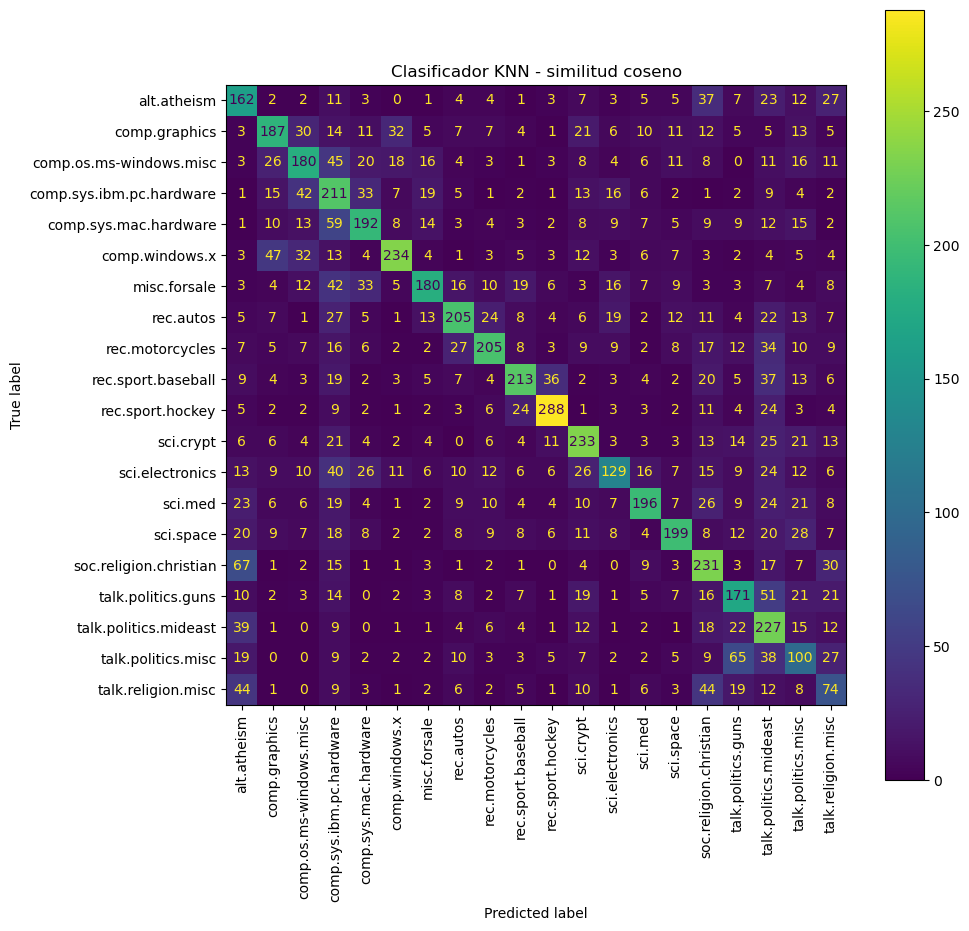

In [8]:
cm_knn = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=newsgroups_test.target_names)

fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
disp.plot(ax=ax, xticks_rotation=90)
ax.set_title("Clasificador KNN - similitud coseno")
plt.show()

In [9]:
# Calculo métricas
print("Clasificador KNN - similitud coseno")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0, average='macro'):.3f}")
print(f"Recuperación: {recall_score(y_test, y_pred, zero_division=0, average='macro'):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred, zero_division=0, average='macro'):.3f}")

Clasificador KNN - similitud coseno
Precision: 0.523
Recuperación: 0.501
F1-score: 0.504


### Punto 3

Entrenamiento del modelo de clasificación de Naïve Bayes con búsqueda de hiperparámetros mediante Optuna.  
Evaluación en set de test con f1-score macro.

In [10]:
from sklearn.model_selection import cross_val_score

ngram_range_list = [(1,1), (1,2), (2,2)]

def objective(trial):
    # Parámetros de Naïve Bayes
    clasif = trial.suggest_categorical("clasif", ["MultinomialNB", "ComplementNB"])
    alpha = trial.suggest_float("alpha", 0, 2)
    fit_prior = trial.suggest_categorical("fit_prior", [True, False])

    if (clasif == "MultinomialNB"):
        clf = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
    else:
        norm = trial.suggest_categorical("norm", [True, False])
        clf = ComplementNB(alpha=alpha, fit_prior=fit_prior, norm=norm)

    # Parámetros de TfidfVectorizer
    strip_accents = trial.suggest_categorical("strip_accents", ["ascii", "unicode", None])
    lowercase = trial.suggest_categorical("lowercase", [True, False])
    analyzer = trial.suggest_categorical("analyzer", ['word', 'char', 'char_wb'])
    stop_words = None
    if (analyzer == 'word'):
        stop_words = trial.suggest_categorical("stop_words", ['english', None])
    ngram_range = trial.suggest_int("ngram_range", 0, 2)
    max_df = trial.suggest_float("max_df", 0.9, 1.0)
    min_df = trial.suggest_int("min_df", 1, 5)

    # Vectorizo el dataset de train
    tfidfvect = TfidfVectorizer(strip_accents=strip_accents, lowercase=lowercase, analyzer=analyzer, stop_words=stop_words, 
                                ngram_range=ngram_range_list[ngram_range], max_df=max_df, min_df=min_df)
    X_train = tfidfvect.fit_transform(newsgroups_train.data)
    y_train = newsgroups_train.target
    # Vectorizo el dataset de test 
    X_test = tfidfvect.transform(newsgroups_test.data)
    y_test = newsgroups_test.target

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, zero_division=0, average='macro')

    return score


In [11]:
# Para visualización de avance
def champion_callback(study, frozen_trial):
    """
    Mostramos menos información, sino es demasiado verboso
    """
    winner = study.user_attrs.get("winner", None)
    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value:.3f} with "
                f"{improvement_percent: .2f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value:.3f}")
    elif frozen_trial.number % 10 == 0:
        print(f"Trial {frozen_trial.number} with no changes.")

In [12]:
import optuna 
from optuna.samplers import TPESampler

# Creo un estudio de Optuna
# Optuna es un poco verboso, dejamos que solo nos muestre logs de errores
optuna.logging.set_verbosity(optuna.logging.ERROR)

sampler = TPESampler(seed=44)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50, callbacks=[champion_callback])
print("End")

Initial trial 0 achieved value: 0.429
Trial 1 achieved value: 0.585 with  26.57% improvement
Trial 4 achieved value: 0.684 with  14.55% improvement
Trial 10 with no changes.
Trial 13 achieved value: 0.692 with  1.08% improvement
Trial 15 achieved value: 0.710 with  2.63% improvement
Trial 20 achieved value: 0.712 with  0.25% improvement
Trial 21 achieved value: 0.713 with  0.16% improvement
Trial 30 with no changes.
Trial 32 achieved value: 0.714 with  0.05% improvement
Trial 40 with no changes.
End


In [13]:
# Obtenemos los mejores hiperparámetros encontrados
best_params = study.best_params
best_params

{'clasif': 'ComplementNB',
 'alpha': 0.14842098807067008,
 'fit_prior': True,
 'norm': False,
 'strip_accents': 'unicode',
 'lowercase': True,
 'analyzer': 'word',
 'stop_words': 'english',
 'ngram_range': 1,
 'max_df': 0.9556989909116328,
 'min_df': 1}

In [14]:
# Construyo nuevamente el vectorizador y el clasificador
if (best_params['clasif'] == "MultinomialNB"):
    clf = MultinomialNB(alpha=best_params['alpha'], fit_prior=best_params['fit_prior'])
else:
    clf = ComplementNB(alpha=best_params['alpha'], fit_prior=best_params['fit_prior'], norm=best_params['norm'])

tfidfvect = TfidfVectorizer(strip_accents=best_params['strip_accents'], lowercase=best_params['lowercase'], analyzer=best_params['analyzer'], stop_words=best_params['stop_words'], 
                            ngram_range=ngram_range_list[best_params['ngram_range']], max_df=best_params['max_df'], min_df=best_params['min_df'])

X_train = tfidfvect.fit_transform(newsgroups_train.data)
y_train = newsgroups_train.target
# Vectorizo el dataset de test 
X_test = tfidfvect.transform(newsgroups_test.data)
y_test = newsgroups_test.target

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

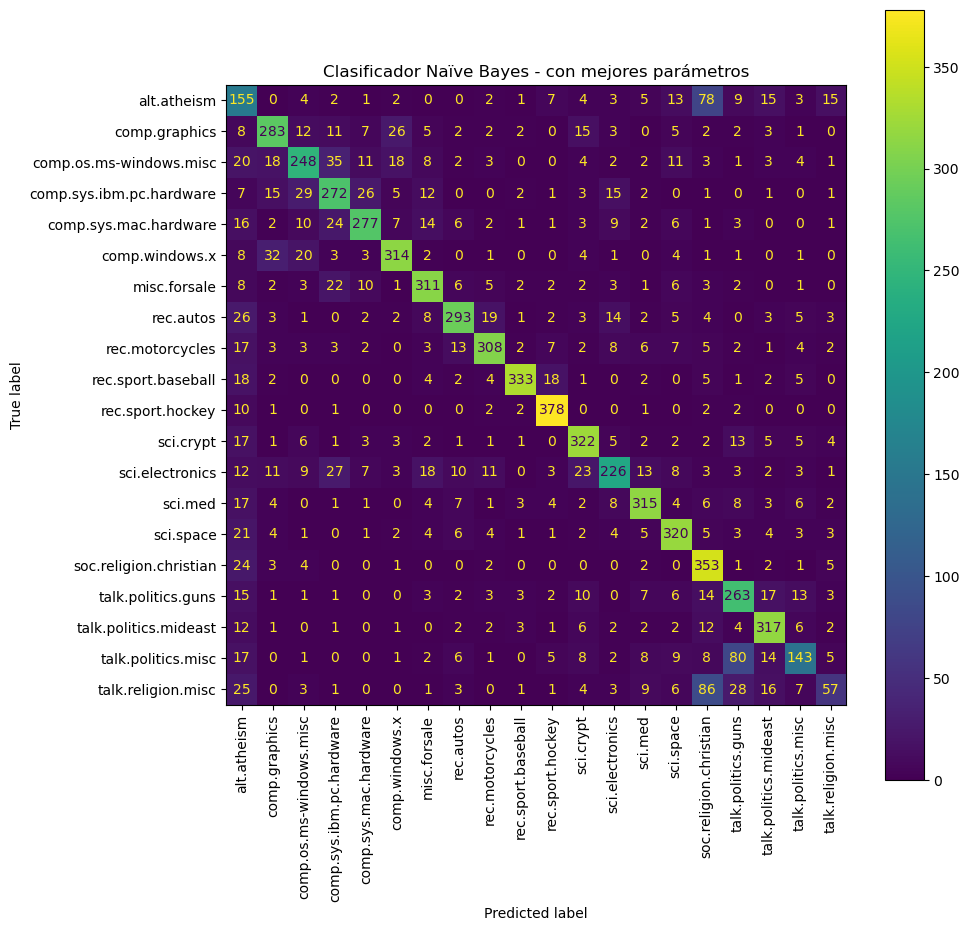

In [15]:
cm_knn = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=newsgroups_test.target_names)

fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
disp.plot(ax=ax, xticks_rotation=90)
ax.set_title("Clasificador Naïve Bayes - con mejores parámetros")
plt.show()

In [16]:
# Calculo métricas
print("Clasificador Naïve Bayes - con mejores parámetros")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0, average='macro'):.3f}")
print(f"Recuperación: {recall_score(y_test, y_pred, zero_division=0, average='macro'):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred, zero_division=0, average='macro'):.3f}")

Clasificador Naïve Bayes - con mejores parámetros
Precision: 0.728
Recuperación: 0.714
F1-score: 0.714
